# pyfssa Tutorial

## Preamble

In [ ]:
from __future__ import division

In [1]:
# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 12, \
                            'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline

In [2]:
import itertools

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/home/sorge/repos/sci/pyfssa/.devenv35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import fssa

## A mock scaling function

In this tutorial, we will demonstrate the *pyfssa* routines with a mock scaling function
\begin{equation}
\tilde{f}(x) = e^{-(x+1)^2}
\end{equation}

In [4]:
def mock_scaling_f(x):
    """Mock scaling function"""
    return np.exp(-(x + 1.0)**2)

In [5]:
x = np.linspace(-4.0, 2.0, num=200)

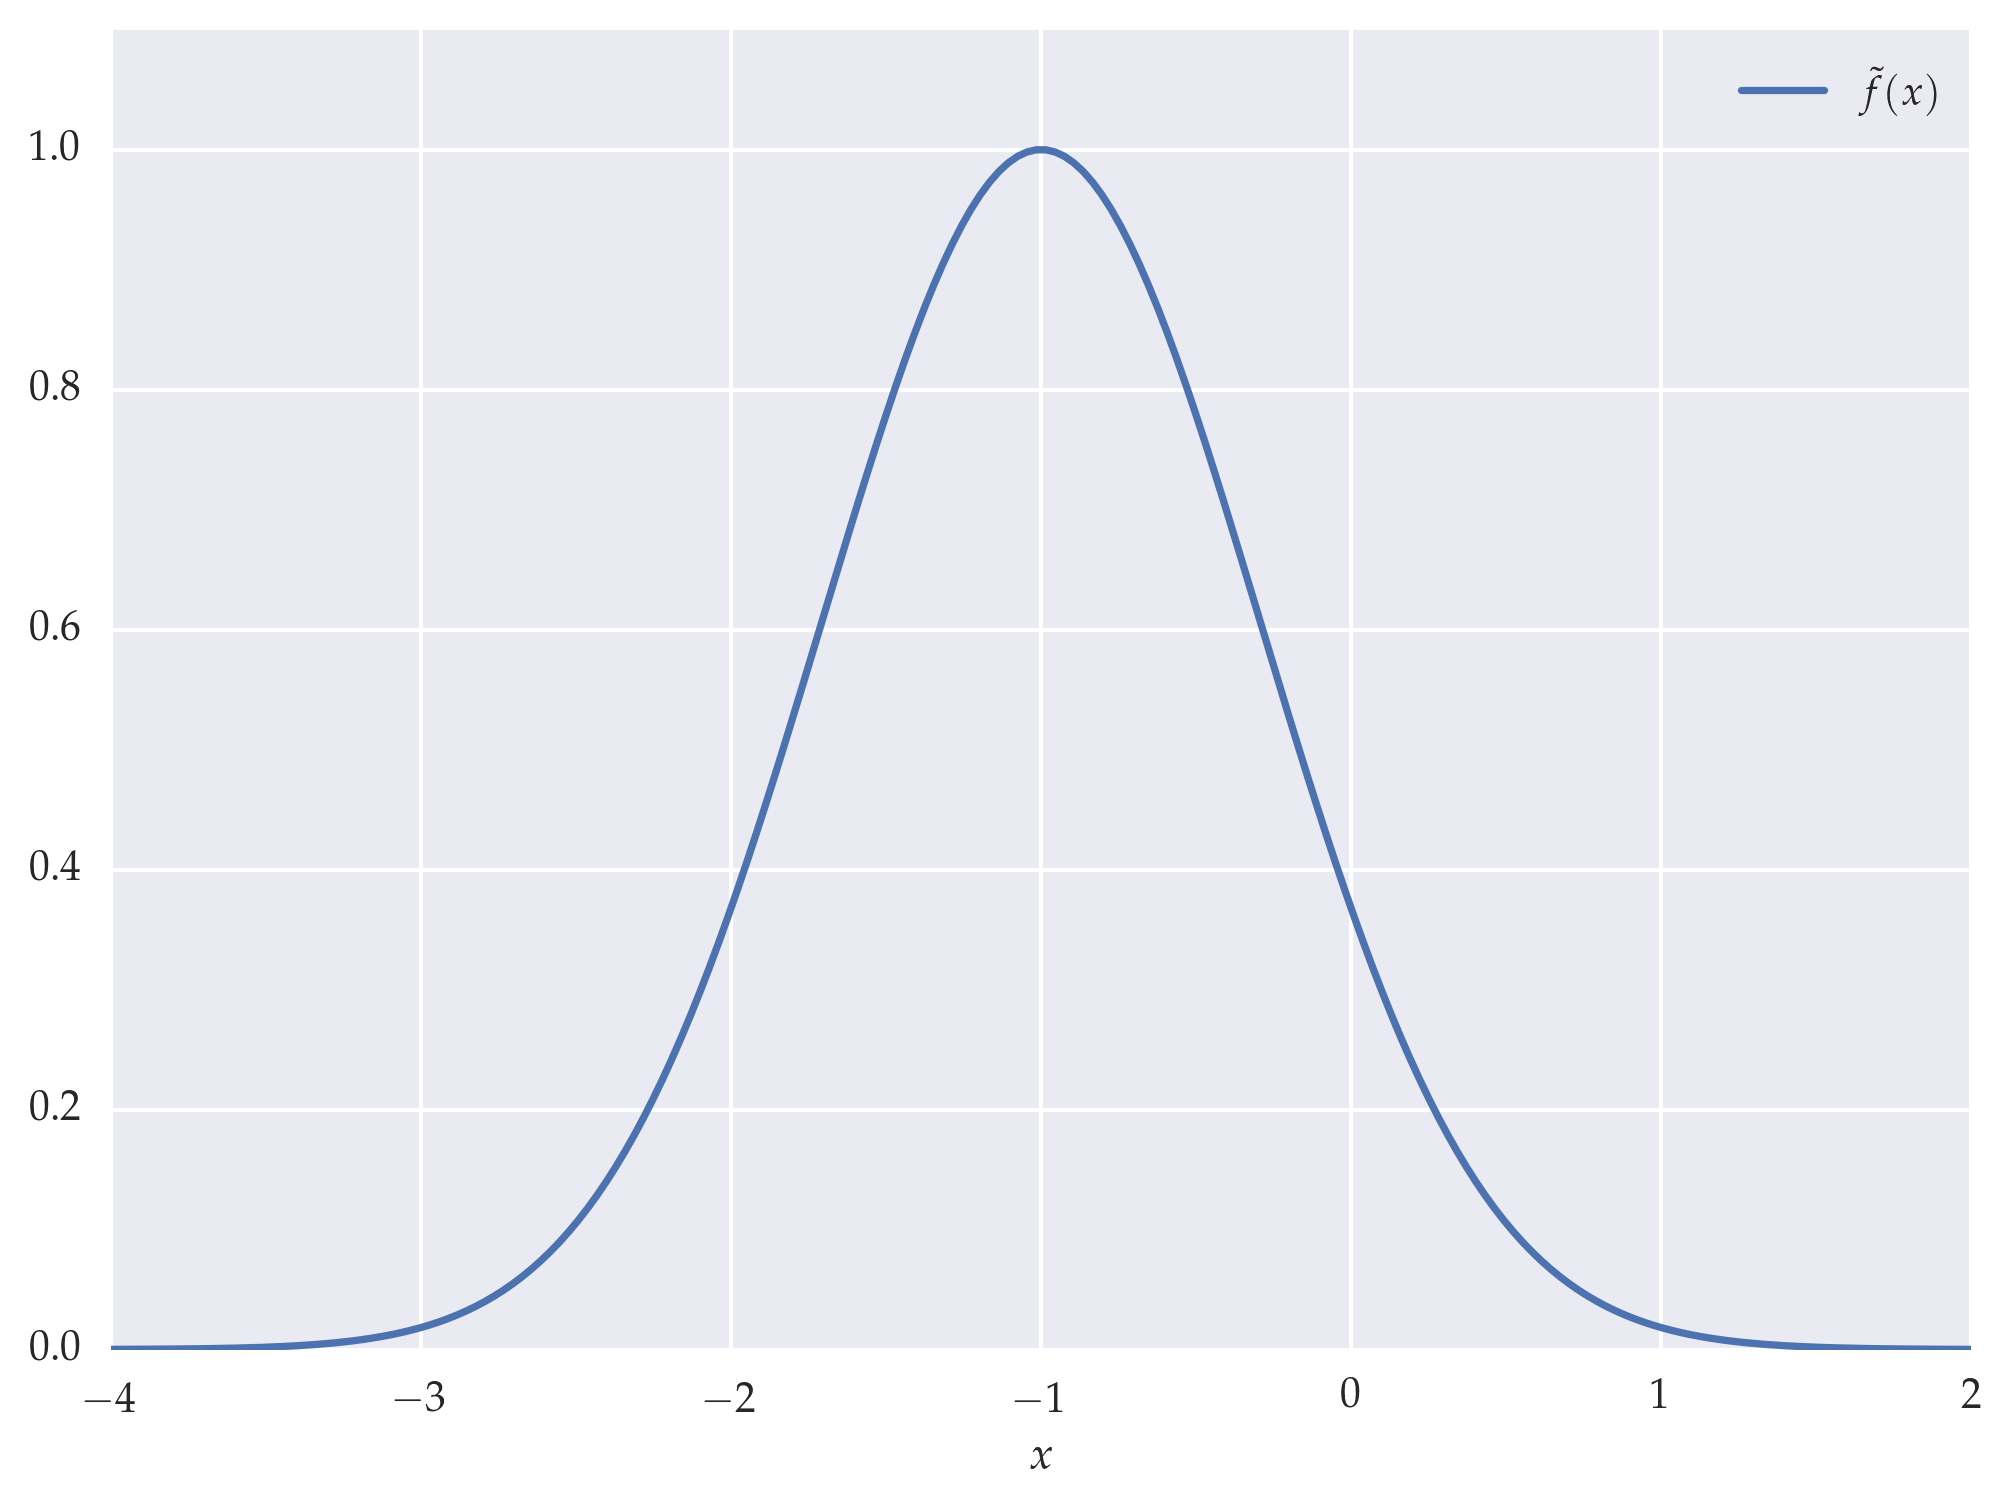

In [6]:
fig, ax = plt.subplots()
ax.plot(x, mock_scaling_f(x), label=r'$\tilde{f}(x)$', rasterized=True)
ax.set_xbound(x.min(), x.max())
ax.set_ybound(0.0, 1.1)
ax.set_xlabel(r'$x$')
ax.legend()
plt.show()

**Figure**: Mock scaling function $\tilde{f}(x) = e^{-(x+1)^2}$

## Precisely mocking scaled data

We generate mock observations $a_{L,\varrho}$ according to the finite-size scaling
\begin{equation}
a_{L, \varrho} = L^{\zeta/\nu} \tilde{f}\left(L^{1/\nu} (\varrho -
\varrho_c)\right)
\end{equation}
with mock exponents $\nu = \frac{5}{2}, \zeta=\frac{3}{2}$ and $\rho_c = \frac{1}{2}$.

In [7]:
def mock_scaled_data(l, rho, rho_c=0.5, nu=2.5, zeta=1.5):
    """Generate scaled data from mock scaling function"""
    return np.transpose(
        np.power(l, zeta / nu) *
        mock_scaling_f(
            np.outer(
                (rho - rho_c), np.power(l, 1 / nu)
            )
        )
    )

In [8]:
rhos = np.linspace(-0.5, 0.8, num=200)
ls = np.logspace(1, 3, num=5).astype(np.int)

In [9]:
# system sizes
ls

array([  10,   31,  100,  316, 1000])

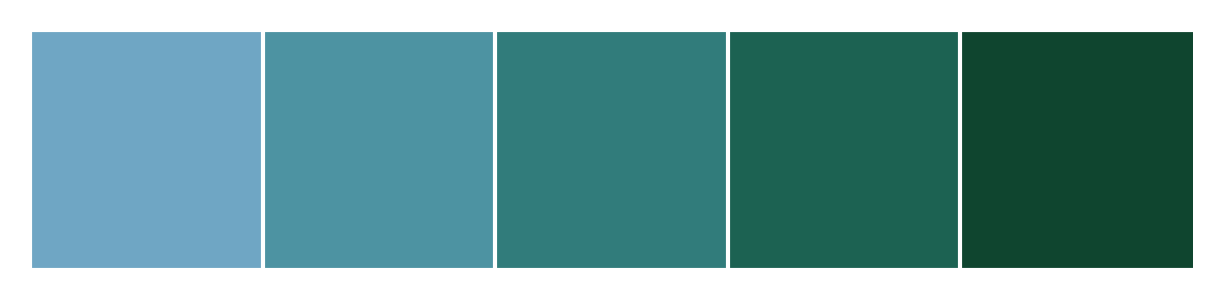

In [10]:
# Define colors
palette = sns.cubehelix_palette(
    n_colors=ls.size, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
)
sns.palplot(palette)

In [11]:
# Generate precisely mocked scaled data
a = mock_scaled_data(ls, rhos)

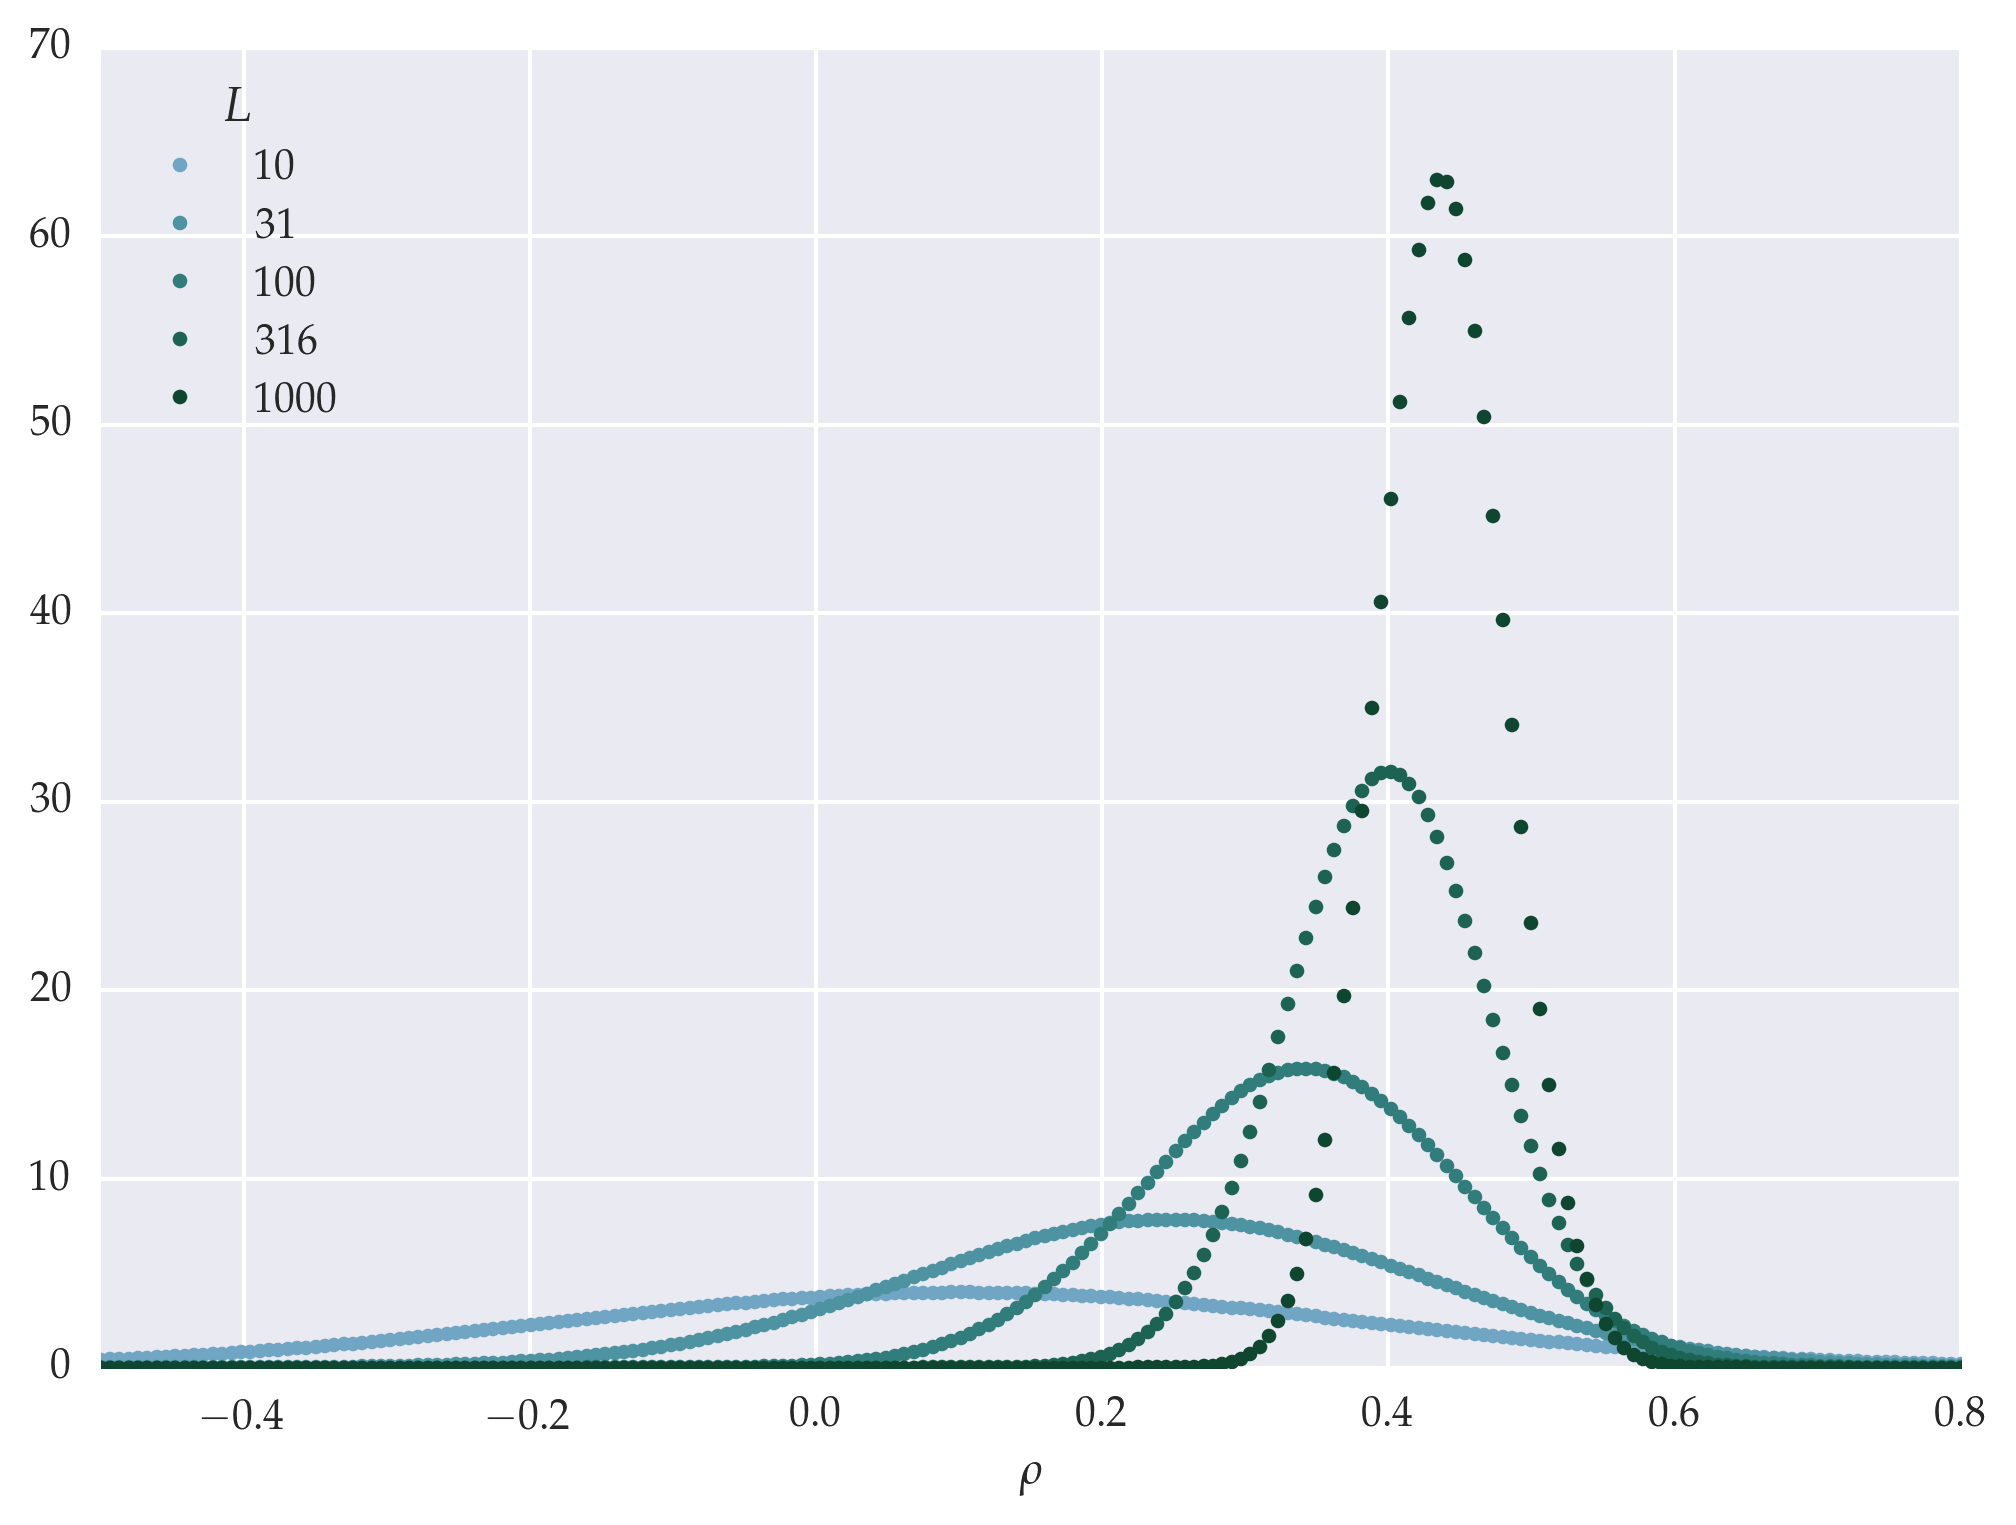

In [12]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', palette))
for l_index, l in enumerate(ls):
    ax.plot(
        rhos, a[l_index, :],
        '.',
        label=r'${}$'.format(l),
        rasterized=True,
    )
ax.set_xbound(rhos.min(), rhos.max())
ax.set_xlabel(r'$\rho$')
ax.legend(title=r'$L$', loc='upper left')
plt.show()

**Figure**: Mocked raw data, precisely sampled from the scaling function and de-scaled.

## Achieving data collapse with the mock data

Our mock data we now want to scale with the **fssa.scaledata** routine.
We compare the quality of the data collapse of several values for the critical exponents, numerically and graphically.

In [13]:
# Put some relative error bars on the precise data
da = a * 0.1

In [14]:
rho_c = np.tile(0.5, (3, 3))
nu = np.tile(2.5, (3, 3))
zeta = np.tile(1.5, (3, 3))
rho_c[0, :] = [0.25, 0.5, 0.75]
nu[1, :] = [2.0, 2.5, 3.0]
zeta[2, :] = [1.0, 1.5, 2.0]

In [15]:
# re-scale data (manually)
scaled_data = list()
quality = list()
for i in range(3):
    my_scaled_data = list()
    my_quality = list()
    for j in range(3):
        my_scaled_data.append(
            fssa.scaledata(
                ls, rhos, a, da,
                rho_c[i, j], nu[i, j], zeta[i, j]
            )
        )
        my_quality.append(fssa.quality(*my_scaled_data[-1]))
    scaled_data.append(my_scaled_data)
    quality.append(my_quality)

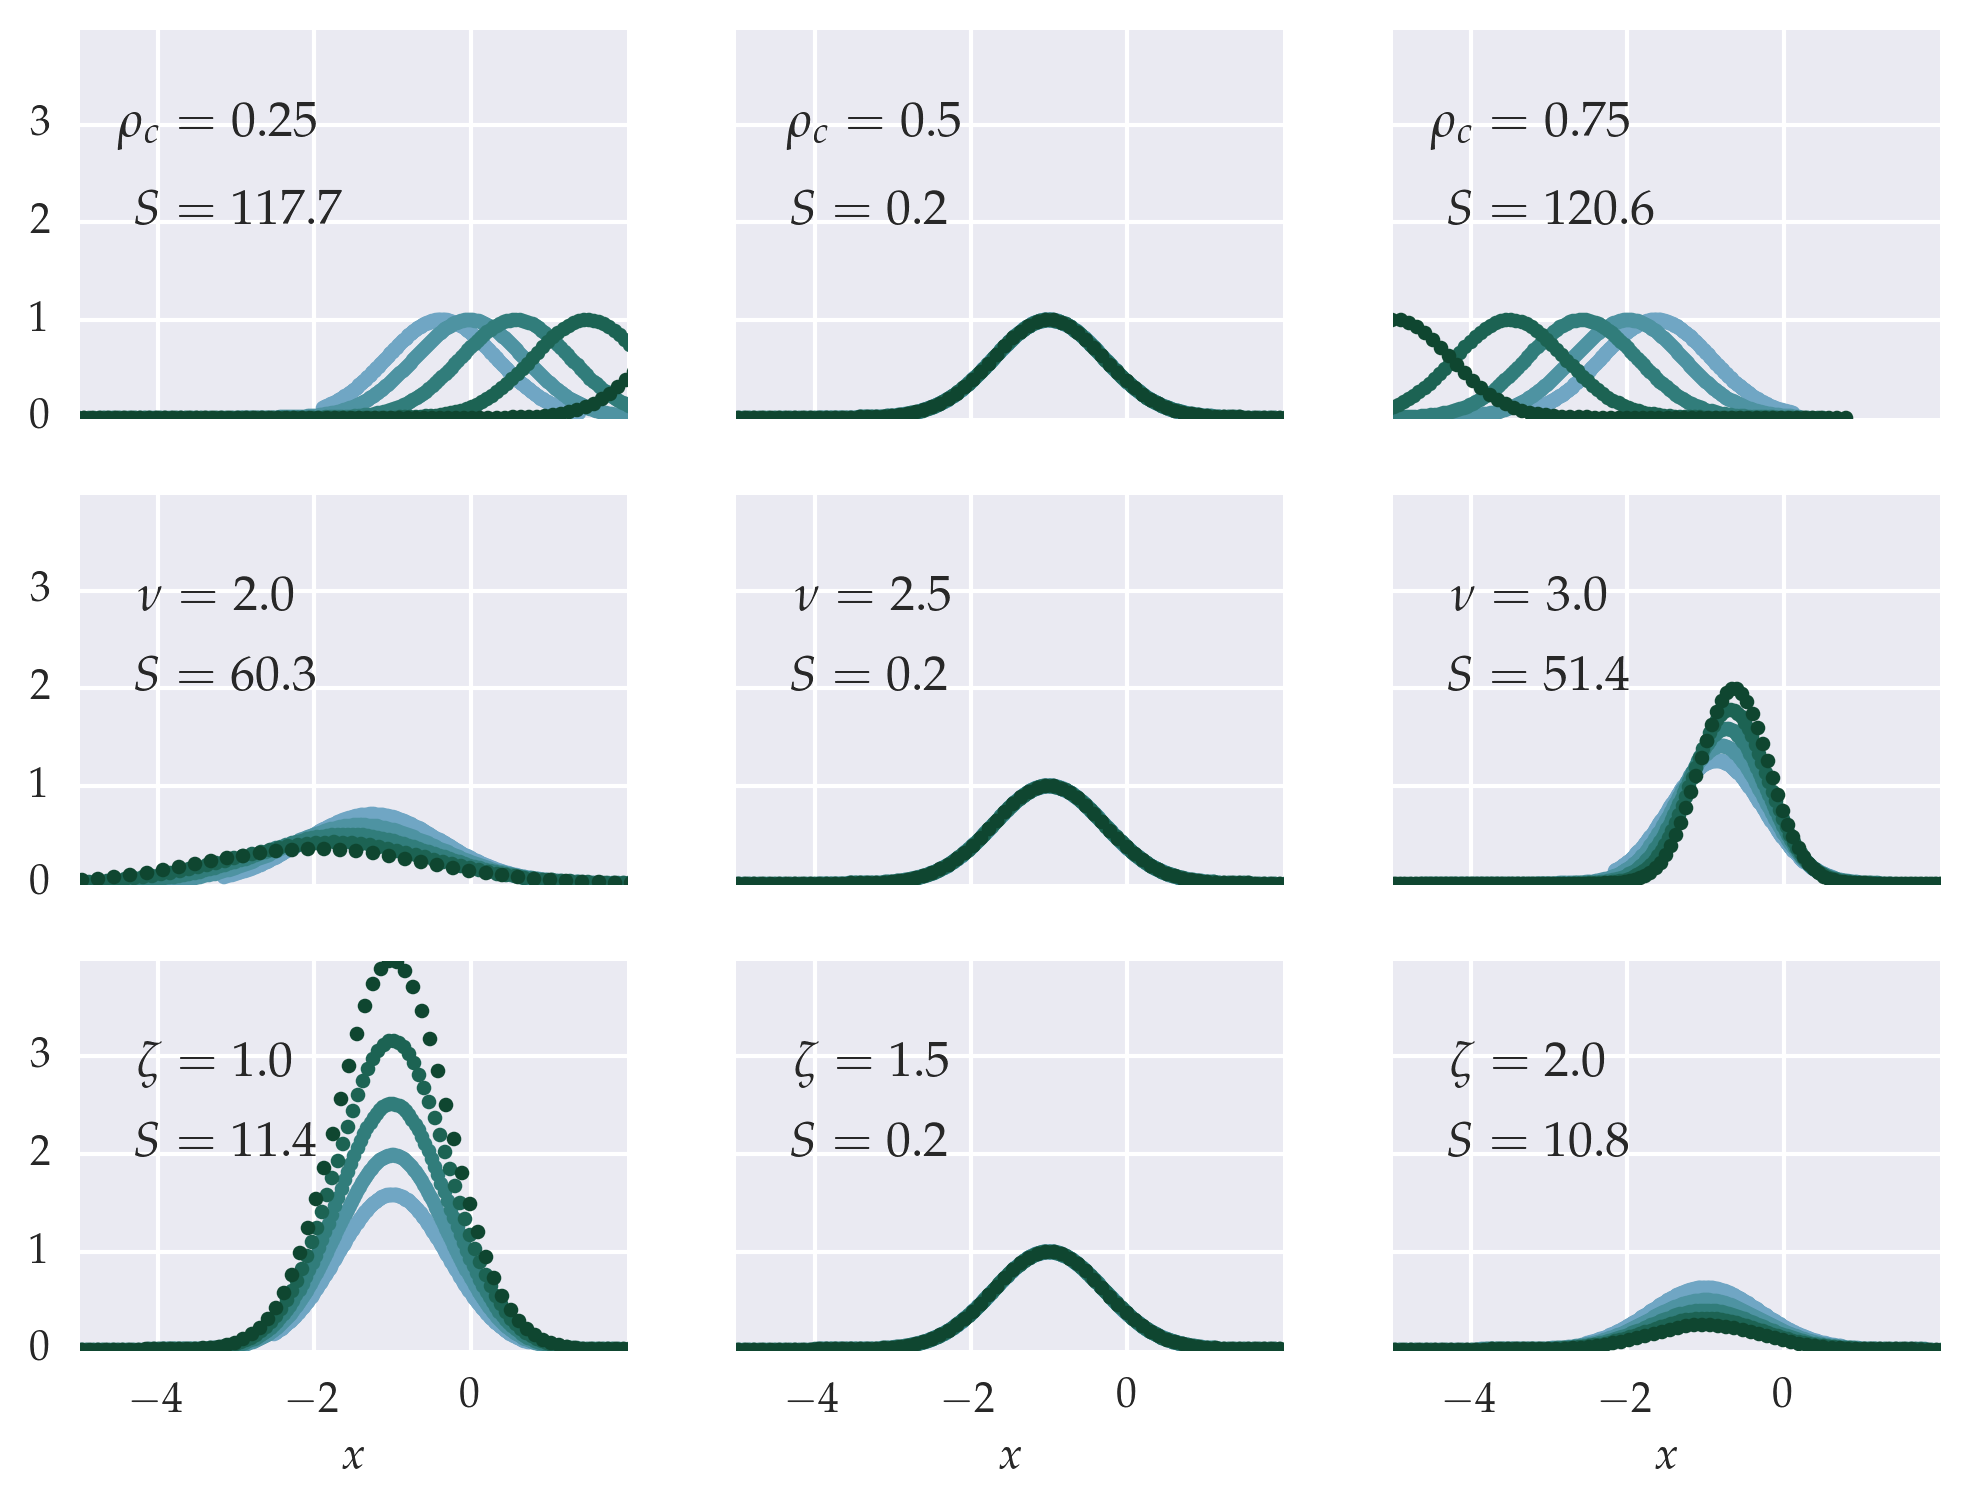

In [16]:
# plot manually re-scaled data
fig, axes = plt.subplots(
    nrows=3, ncols=3, squeeze=True,
    #figsize=(8, 7),
    sharex=True, sharey=True,
)

for (i, j) in itertools.product(range(3), range(3)):
    ax = axes[i, j]
    ax.set_prop_cycle(cycler('color', palette))
    my_scaled_data = scaled_data[i][j]
    for l_index, l in enumerate(ls):
        ax.plot(
            my_scaled_data.x[l_index, :], my_scaled_data.y[l_index, :],
            '.',
            label=r'${}$'.format(l),
            rasterized=True,
        )
    ax.set_xbound(-5, 2)
    if i == 0:
        ax.set_title(
            r'$\rho_c = {}$'.format(rho_c[i, j]),
            position=(0.25, 0.65),
        )
    elif i == 1:
        ax.set_title(
            r'$\nu = {}$'.format(nu[i, j]),
            position=(0.25, 0.65),
        )
    elif i == 2:
        ax.set_title(
            r'$\zeta = {}$'.format(zeta[i, j]),
            position=(0.25, 0.65),
        )
    if i == 2:
        ax.set_xlabel(r'$x$')
        ax.set_xticks([-4, -2, 0, ])
    if j == 0:
        ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.text(
        0.1, 0.5,
        r'$S={:.1f}$'.format(quality[i][j]),
        transform=ax.transAxes,
    )
    
plt.show()

**Figure**: Scaling the mock data with varying exponents. The true exponents are in the middle column as the critical parameter $\rho_c = \frac{1}{2}$ and $\nu = \frac{5}{2}$, $\zeta = \frac{3}{2}$, as signified by the data collapse onto the single master curve and the quality-of-fit $S$ (smaller is better).

## Auto-scaling the mock data

Now that we have an idea of the approximate range of the exponents, we employ the *fssa.autoscale* function to algorithmically determine accurate values and their errors.

In [17]:
ret = fssa.autoscale(ls, rhos, a, da, 0.4, 1.8, 2.2)

In [18]:
ret

       message: 'Optimization terminated successfully.'
           rho: 0.49998651420931617
            nu: 2.5029600101429974
           fun: 0.17526760830186447
          zeta: 1.4952017139156362
         varco: array([[  8.73865721e-06,   3.63193042e-05,  -2.29670016e-05],
       [  3.63193042e-05,   1.92714401e-04,  -2.37981434e-04],
       [ -2.29670016e-05,  -2.37981434e-04,   4.25360904e-03]])
 final_simplex: (array([[ 0.49998651,  2.50296001,  1.49520171],
       [ 0.50050506,  2.5043243 ,  1.50331343],
       [ 0.50051167,  2.50509256,  1.49581337],
       [ 0.49998317,  2.50366177,  1.50347298]]), array([ 0.17526761,  0.17641794,  0.17700658,  0.18406708]))
        errors: array([ 0.00295612,  0.01388216,  0.0652197 ])
             x: array([ 0.49998651,  2.50296001,  1.49520171])
         dzeta: 0.065219698289192385
        status: 0
       success: True
           dnu: 0.013882161249126912
           nit: 42
          nfev: 74
          drho: 0.0029561219887328798

In [19]:
auto_scaled_data = fssa.scaledata(ls, rhos, a, da, ret.rho, ret.nu, ret.zeta)

In [20]:
# critical exponents and errors, quality of data collapse
print(ret.rho, ret.drho)
print(ret.nu, ret.dnu)
print(ret.zeta, ret.dzeta)
print(ret.fun)

0.499986514209 0.00295612198873
2.50296001014 0.0138821612491
1.49520171392 0.0652196982892
0.175267608302


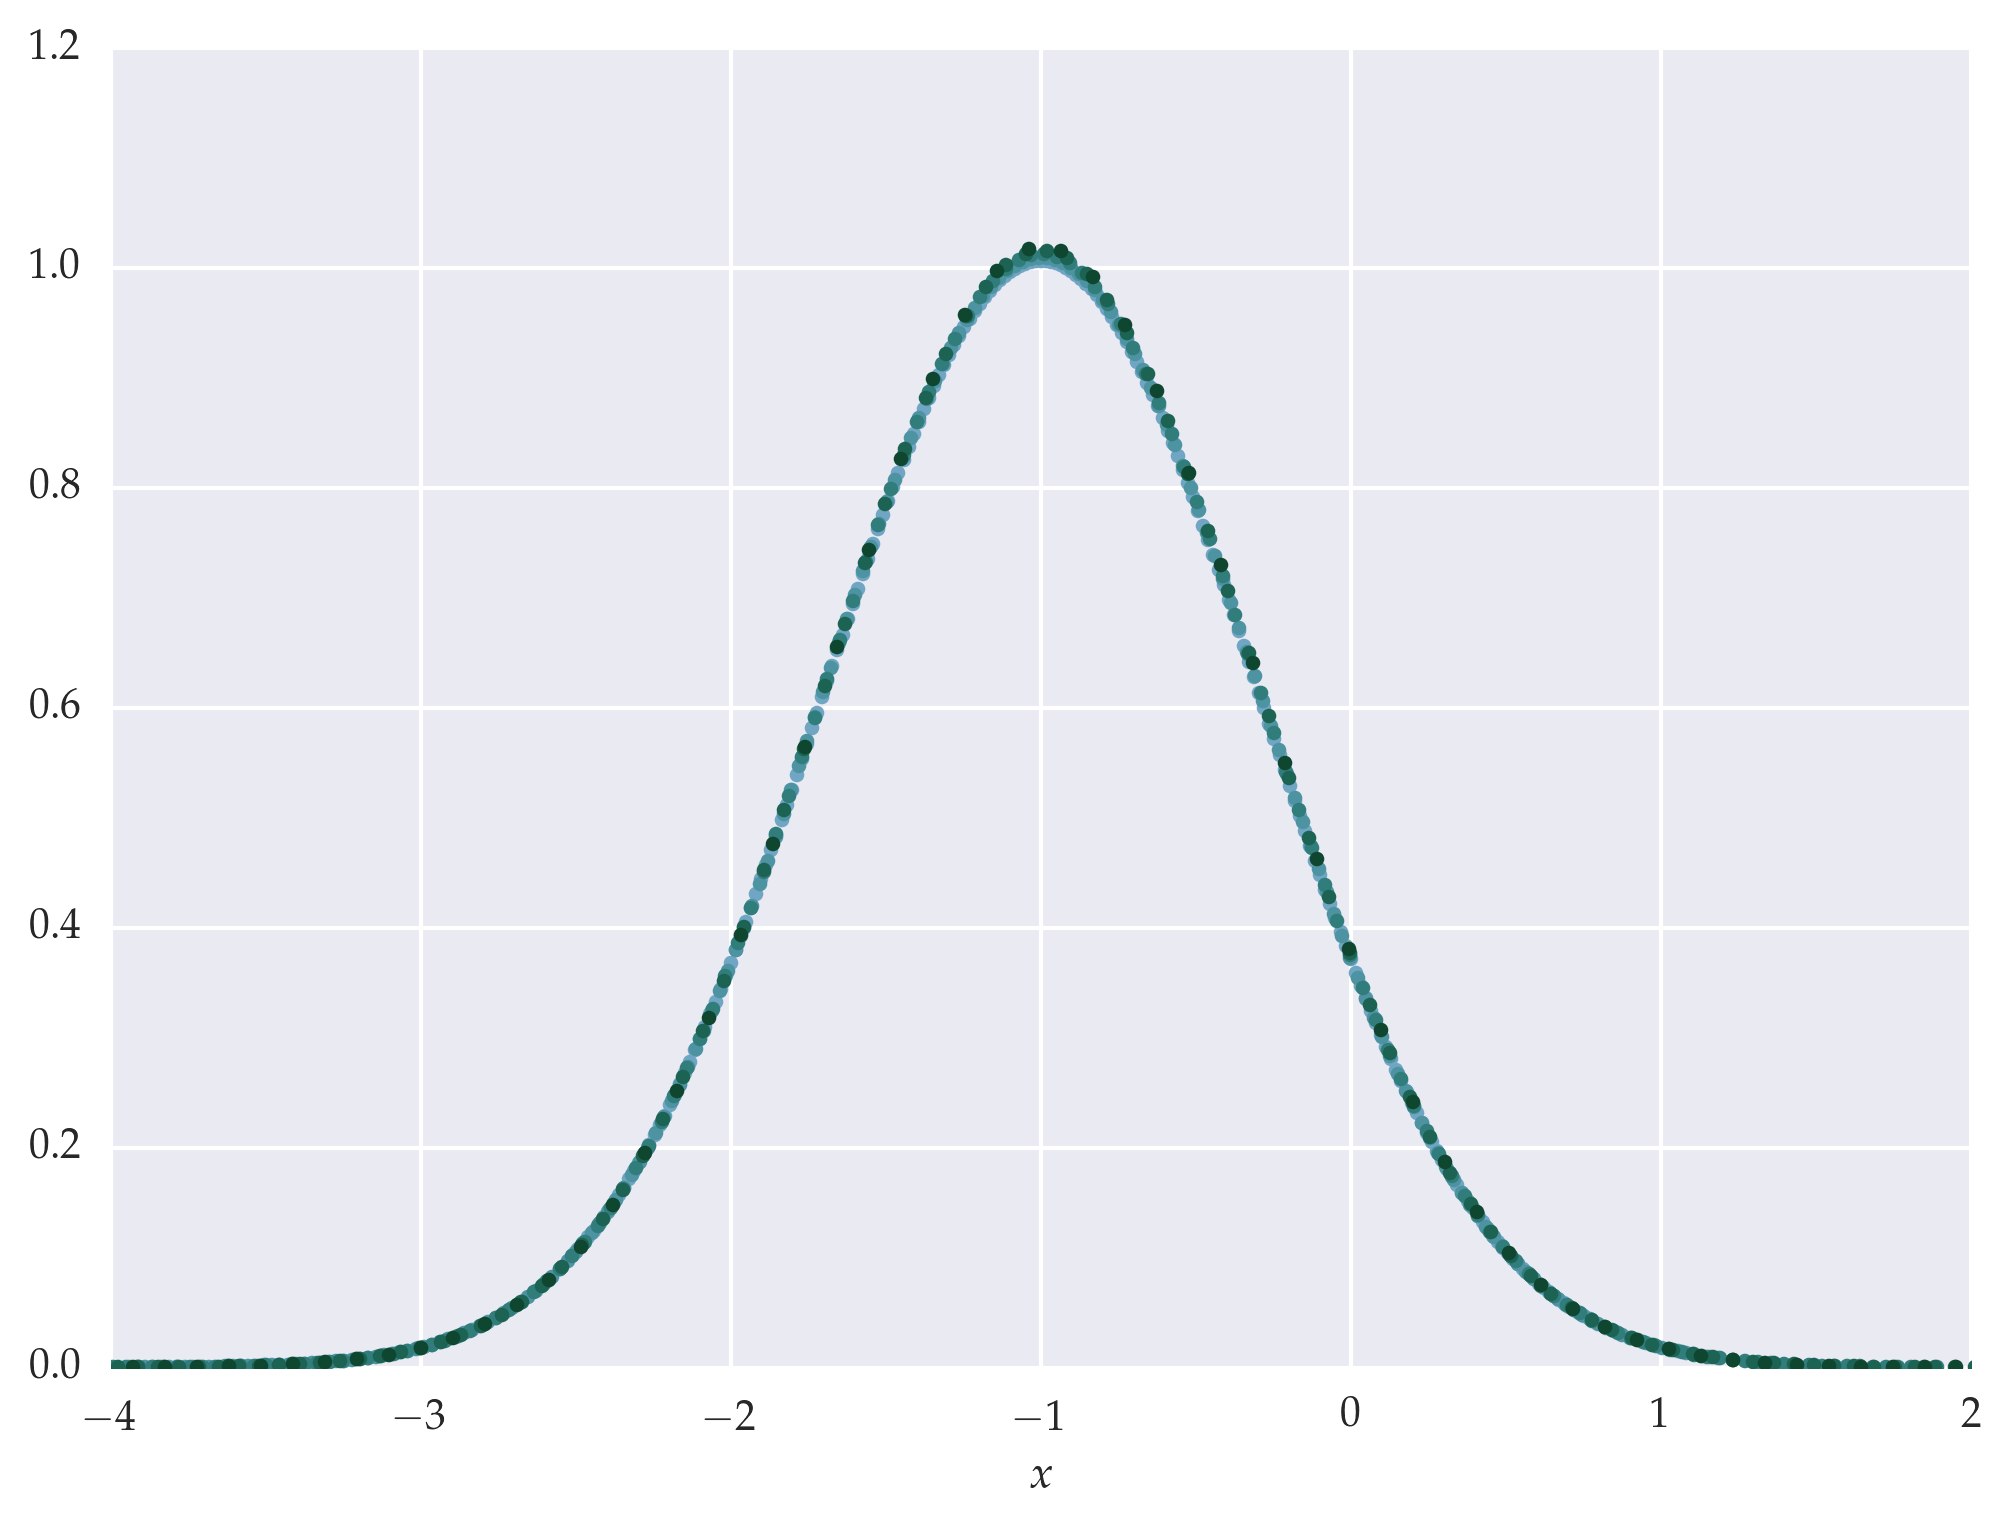

In [21]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', palette))
ax.plot(
    auto_scaled_data.x.T, auto_scaled_data.y.T,
    '.',
)
ax.set_xbound(-4, 2)
ax.set_xlabel(r'$x$')
plt.show()

**Figure**: Auto-scaling with *pyfssa* leads to data collapse of the mock data onto the original scaling function.

## Auto-scaling noisy mock data

In [22]:
noisy_a = a + a * 0.015 * np.random.standard_normal(a.shape)

In [23]:
noisy_ret = fssa.autoscale(ls, rhos, noisy_a, da, 0.4, 1.8, 2.2)

In [24]:
noisy_ret

       message: 'Optimization terminated successfully.'
           rho: 0.49979612592224609
            nu: 2.5018014976584313
           fun: 0.19734634712706023
          zeta: 1.5036671478584973
         varco: array([[  9.53621435e-06,   3.91298047e-05,  -2.84083526e-05],
       [  3.91298047e-05,   2.09742160e-04,  -2.92044395e-04],
       [ -2.84083526e-05,  -2.92044395e-04,   4.95583290e-03]])
 final_simplex: (array([[ 0.49979613,  2.5018015 ,  1.50366715],
       [ 0.50029063,  2.50273293,  1.50083439],
       [ 0.500754  ,  2.50594539,  1.49960779],
       [ 0.50059354,  2.50430462,  1.51015554]]), array([ 0.19734635,  0.19844804,  0.20223142,  0.20427539]))
        errors: array([ 0.00308808,  0.01448248,  0.07039768])
             x: array([ 0.49979613,  2.5018015 ,  1.50366715])
         dzeta: 0.070397676820182428
        status: 0
       success: True
           dnu: 0.014482477694416154
           nit: 41
          nfev: 72
          drho: 0.0030880761568600015

In [25]:
noisy_auto_scaled_data = fssa.scaledata(
    ls, rhos, noisy_a, da, noisy_ret.rho, noisy_ret.nu, noisy_ret.zeta
)

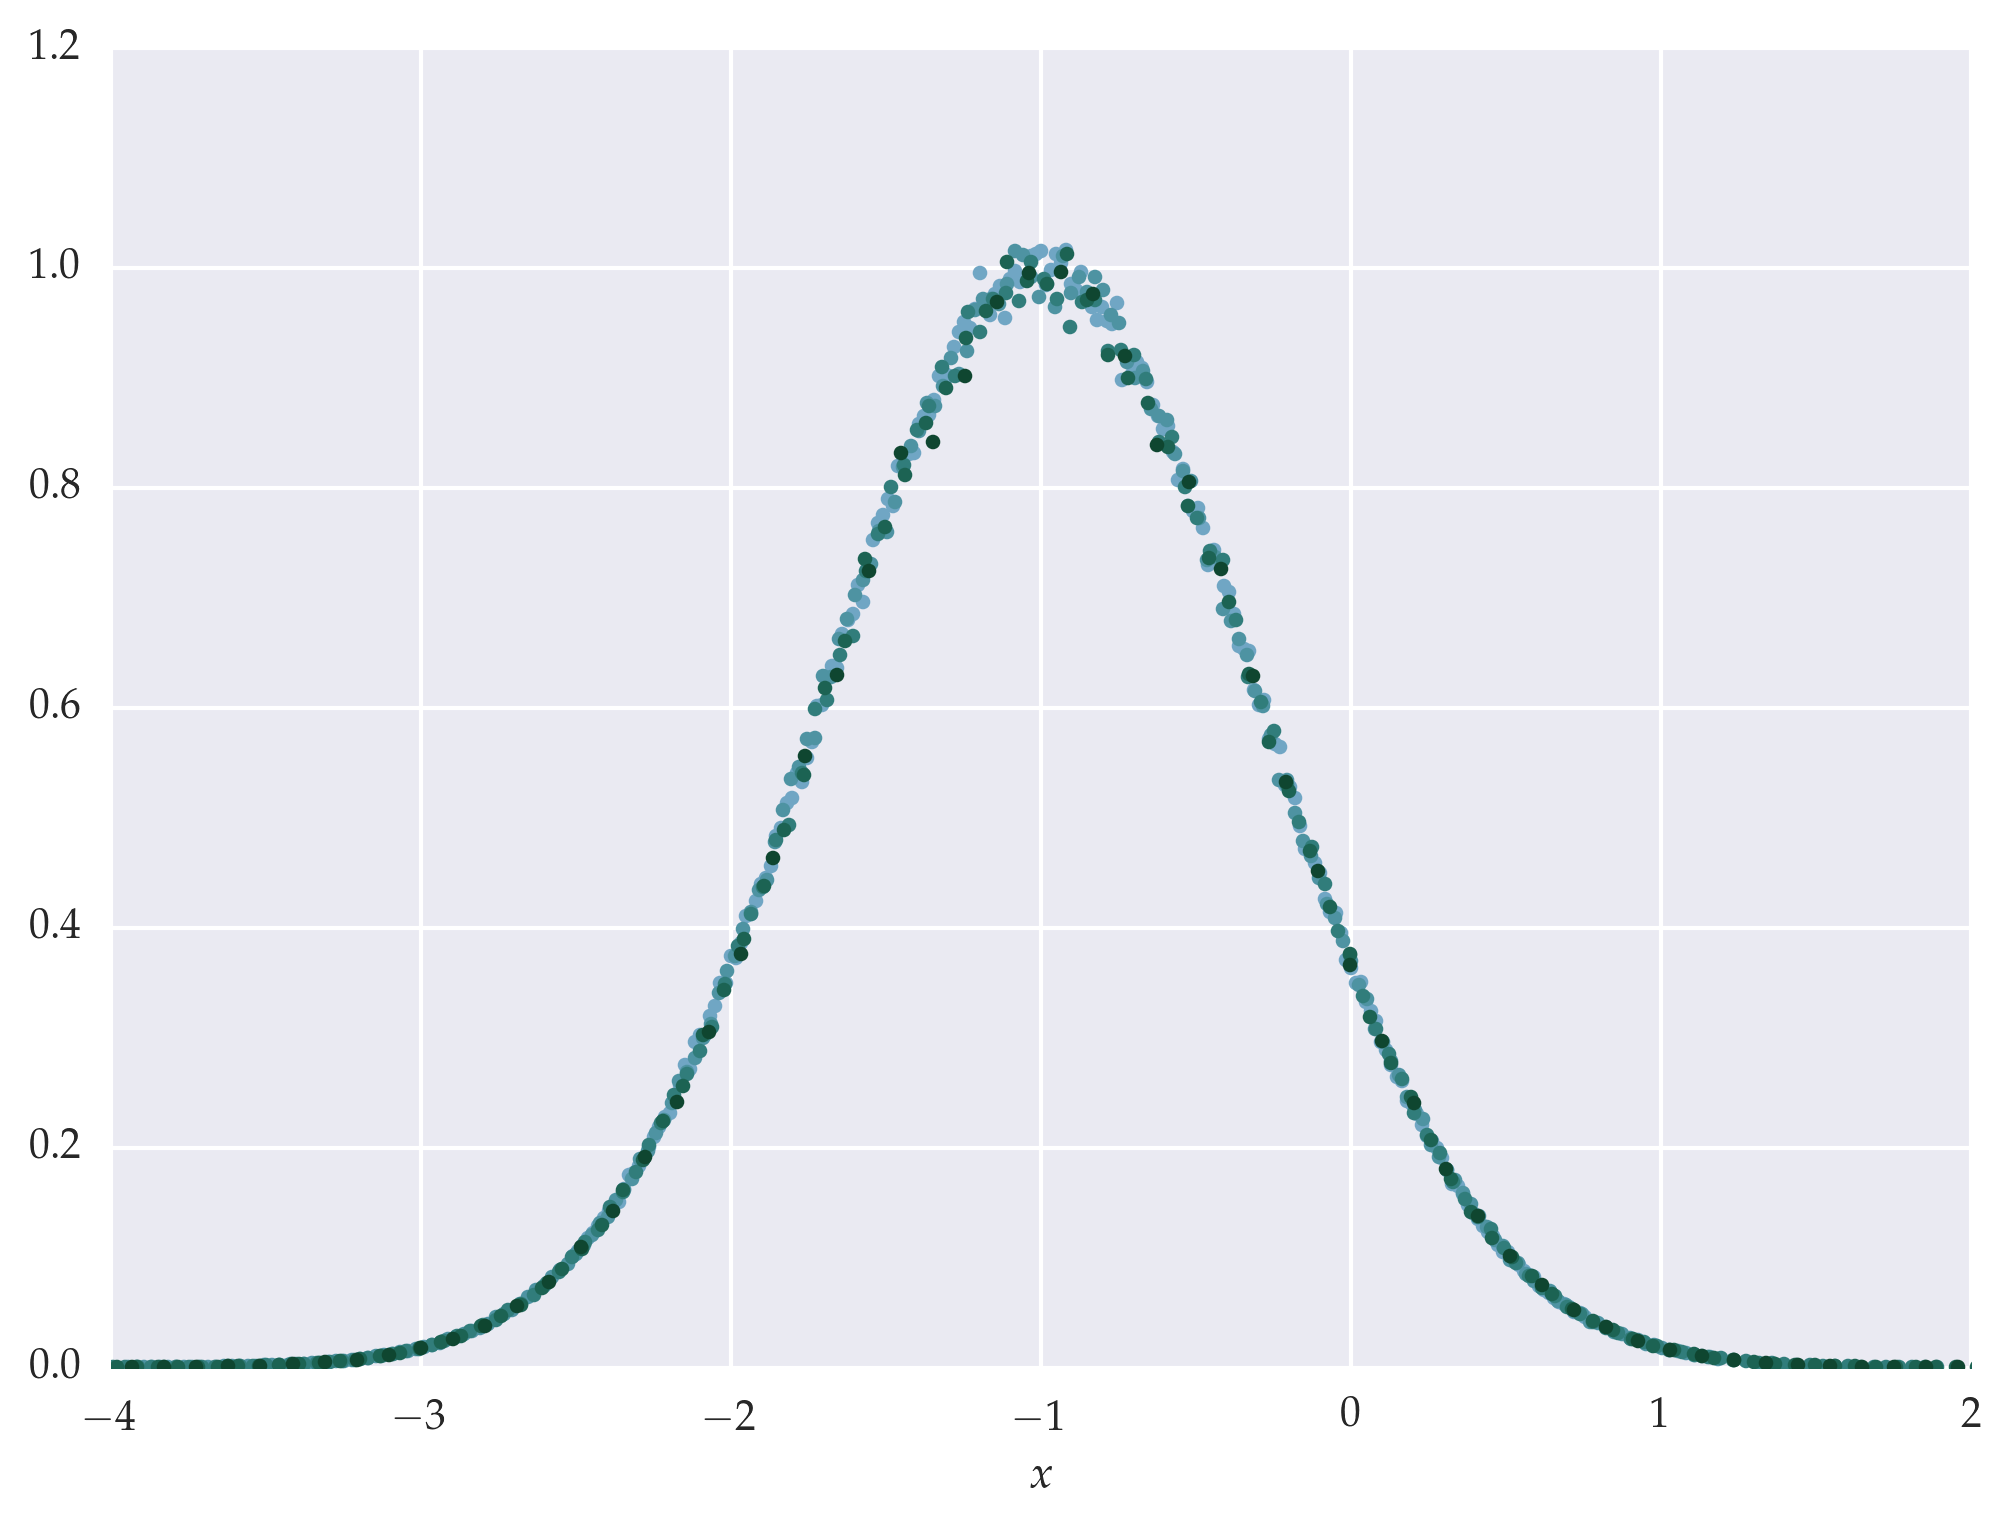

In [26]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', palette))
ax.plot(
    noisy_auto_scaled_data.x.T, noisy_auto_scaled_data.y.T,
    '.',
)
ax.set_xbound(-4, 2)
ax.set_xlabel(r'$x$')
plt.show()

**Figure**: Auto-scaling with *pyfssa* leads to data collapse of the noisy mock data onto the original scaling function.